# **YOLOv5 Object Detection on Traffic Signs Dataset**

This notebook explains training custom YOLOv5 model for object detection in colab using the custom data from Google Drive. I am using "Traffic Signs Dataset" from kaggle which is already available in yolo format.
https://www.kaggle.com/valentynsichkar/traffic-signs-dataset-in-yolo-format


**1. Setting Up Google Colab**

Google Colab is an online environment similar to Jupiter notebook where you can train deep learning models on GPU. The free plan of Google Colab allows you to train the deep learning model for up to 12 hrs before the runtime disconnects. By visiting the runtime section change run type to GPU.

In [1]:
!nvidia-smi # to check and monitoring of NVIDIA GPU devices. 

Mon May 15 21:02:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**2. Cloning The YOLOv5 repository**

We will now clone the YOLOv5 repository provided by Ultralytics in our Colab environment.

In [2]:
#clone YOLOv5
!git clone https://github.com/ultralytics/yolov5

# Change the current working directory.
%cd yolov5 
!pip install -qr requirements.txt # install dependencies from requirements to use Yolov5 with quiet option

Cloning into 'yolov5'...
remote: Enumerating objects: 15672, done.
remote: Total 15672 (delta 0), reused 0 (delta 0), pack-reused 15672
Receiving objects: 100% (15672/15672), 14.43 MiB | 21.61 MiB/s, done.
Resolving deltas: 100% (10745/10745), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.2/585.2 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 21.5 MB/s eta 0:00:00


In [3]:
# improts and checking the GPUs available
import torch
import os
from IPython.display import Image  # to display images

print("Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})


**3. Mounting Google Drive**

I have uploaded traffic_sign_data folder to Google drive in the *'MyDrive/datasets/traffic_sign_data/'* path, I will mount drive using the below code. (It will ask you to enter the authorization code that you can by clicking the link that will appear below). The annotated data has been divided in such a way that the images and the labels (text files) are separate. 

Organized train and val images and labels according to the example below. YOLOv5 assumes /traffic_sign_data is inside a /datasets directory next to the /yolov5 directory. YOLOv5 locates labels automatically for each image by replacing the last instance of /images/ in each image path with /labels/. 



```
../datasets/traffic_sign_data/images/train/00000.jpg  # image

../datasets/traffic_sign_data/labels/train/00000.txt  # label
```

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# check the uploaded data in drive
!ls '/content/drive/MyDrive/datasets/traffic_sign_data'
!ls '/content/drive/MyDrive/datasets/traffic_sign_data/images'

images
train


**YOLOV5 format:**

The YOLO format, with one *.txt file per image (if no objects in image, no *.txt file is required). The *.txt file specifications are:

One row per object
Each row is class x_center y_center width height format.

Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
Class numbers are zero-indexed (start from 0).

In [7]:
# Checking the size of images and displaying them
import numpy as np
import cv2
# Image shape in Training
image = cv2.imread('/content/drive/MyDrive/datasets/traffic_sign_data/images/train/00000.jpg')
height = np.size(image, 0)
width = np.size(image, 1)
print ("shape of the training image {}, {}".format(height, width))
# Image shape in validation
image = cv2.imread('/content/drive/MyDrive/datasets/traffic_sign_data/images/val/00003.jpg')


shape of the training image 800, 1360


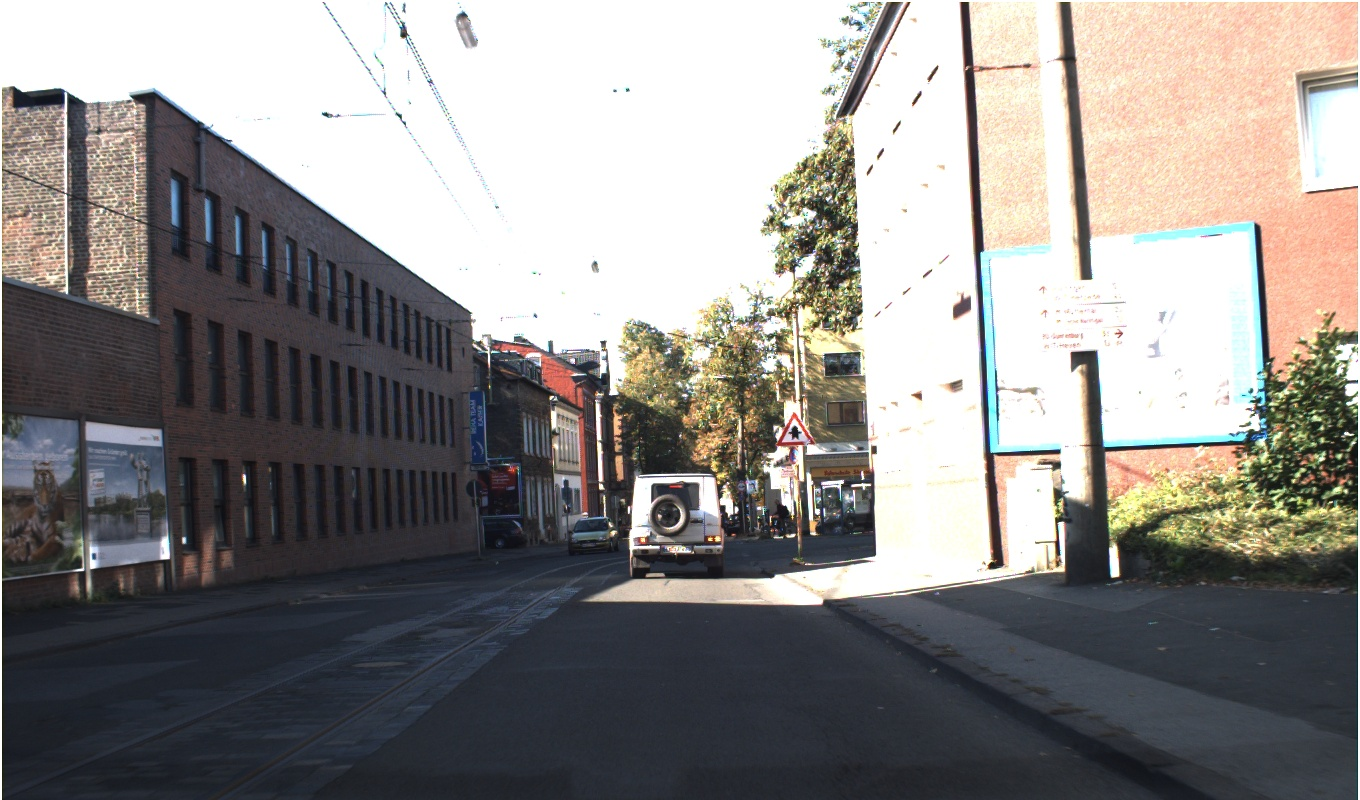

In [8]:
# dispying with different width
Image(filename='/content/drive/MyDrive/datasets/traffic_sign_data/images/train/00000.jpg', width=800) 

In [10]:
# dispying with different width
Image(filename='/content/drive/MyDrive/datasets/traffic_sign_data/images/val/00084.jpg', width=800) 

FileNotFoundError: ignored

In [ ]:
# dispying with different width
Image(filename='/content/drive/MyDrive/datasets/traffic_sign_data/images/val/00323.jpg', width=800)

**4. Create traffic_sign_data.yaml (dataset config file)**

"traffic sign data" is a small dataset composed of the first 374 images in train and 88 images in validation set. 

data/traffic_sign_data.yaml, created below, is the dataset config file that defines:

1) the dataset root directory path and relative paths to train / val / test image directories (or *.txt files with image paths)

2) nc: the number of classes

3) names: a list of class names

In [ ]:
# I will write the contents of the cell to a file
%%writefile /content/yolov5/data/traffic_sign_data.yaml 

# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: /content/drive/MyDrive/datasets/traffic_sign_data # dataset root dir
train: images/train/ # train images (relative to 'path')
val: images/val/ # val images (relative to 'path')
test:  # test images (optional)

# Classes
nc: 4  # number of classes

# class names
names: ['speed limit', 'yield', 'mandatory', 'other']


**5. Training Our Custom Traffic Sign Detector Model**

I am training a YOLOv5s model on traffic sign data by specifying dataset, batch-size, image size and pretrained --weights yolov5s.pt. Pretrained weights are auto-downloaded from the latest YOLOv5 release.

Parameters:

–data: Path to the data configuration file

--weights: specify a path to weights to start transfer learning from. yolov5s.pt (starting from Pretrained weights)

–img: Input image size

–batch: Size of a batch (model weights are updated with each batch).

–epochs: No of epochs.

--cache: cache images for faster training, cache images in "ram" (default) or "disk

In [ ]:
# Training YOLOv5s on traffic sign dataset for 30 epochs
!python train.py --img 1360 --batch 16 --epochs 30 --data traffic_sign_data.yaml --weights yolov5s.pt --cache

All training results are saved to runs/train/ with incrementing run directories, i.e. runs/train/exp2, runs/train/exp3 etc.

**6.Evaluate Custom YOLOv5 Detector Performance**

Training losses and performance metrics are saved to Tensorboard and also to a logfile.

At the end of the training, two files should be saved in yolov5/runs/train/exp/weights: last.pt and best.pt. We’ll use best.pt.

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs/train/

**Local Logging:**

All results are logged by default to runs/train, with a new experiment directory created for each new training as runs/train/exp2, runs/train/exp3, etc. View train and val jpgs to see mosaics, labels, predictions and augmentation effects. Note an Ultralytics Mosaic Dataloader is used for training (shown below), which combines 4 images into 1 mosaic during training.

val_batch0_labels.jpg shows validation batch 0 mosaics and labels:

In [ ]:
# Image(filename='/content/yolov5/runs/train/exp/train_batch0.jpg', width=800)  # train batch 0 mosaics and labels
Image(filename='/content/yolov5/runs/train/exp/val_batch0_labels.jpg', width=800)  # test batch 0 labels
# Image(filename='/content/yolov5/runs/train/exp/val_batch0_pred.jpg', width=800)  # test batch 0 predictions

Training losses and performance metrics are also logged to Tensorboard and a custom results.txt logfile which is plotted as results.png (below) after training completes.

In [ ]:
Image(filename='/content/yolov5/runs/train/exp/results.png', width=800)

 **6. Run Inference With Custom YOLOv5 Object Detector Trained Weights**

Inference Command: Run the ‘detect.py’ file to run inference on the custom dataset.

–source: The path to the image to perform inference on.

–weights: Weights file of the trained model.


–conf: Minimum confidence value to consider a prediction as good.

–save-txt: Flag parameters enables saving of text files containing the coordinates of bounding boxes.

**Inference on Images:**

In [ ]:
!python detect.py  --source /content/drive/MyDrive/datasets/traffic_sign_data/images/val/00323.jpg --weights runs/train/exp/weights/best.pt --conf 0.25 --save-txt

In [ ]:
Image(filename='/content/yolov5/runs/detect/exp/00323.jpg', width=800)

In [ ]:
# dispying with different width
!python detect.py  --source /content/drive/MyDrive/datasets/traffic_sign_data/images/val/00084.jpg --weights runs/train/exp/weights/best.pt --conf 0.25 --save-txt

In [ ]:
Image(filename='/content/yolov5/runs/detect/exp5/00084.jpg', width=800)

**Inference on Video:**

In [ ]:
!python detect.py  --source /content/drive/MyDrive/datasets/traffic-sign-to-test.mp4 --weights runs/train/exp/weights/best.pt --conf 0.25 --save-txt

In [ ]:
#export your model's weights for future use
from google.colab import files
files.download('./runs/train/exp/weights/best.pt')

References:


1.https://github.com/ultralytics/yolov5

2.https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data

3.https://blog.roboflow.com/how-to-train-yolov5-on-a-custom-dataset/




